# Similarity Search with UCLA Courses – BERT (`bert-base-uncased`)

### Philippe Krepel, MATH156

This notebook implements similarity vector search with UCLA courses. This is a step-by-step guide of what it does:

- Scrapes UCLA course data

- Converts each course description into text embeddings using the BERT model and stores them in JSON

- Applies similarity search in-between courses, as well as against user input.

## Required Installations

In [114]:
!pip install -U weaviate-client


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [115]:
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install openai


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Scraping UCLA course descriptions (Optional, since I will provide the JSON file of the scraped data)

Here, we make use of UCLA's public API to get relevant information about all courses available at UCLA. The details about this code are outside the scope of the paper and involve general API and web-scraping skills.

For each course, we save the following information to serve as meta-data (data that will not be converted to embeddings):

- Subject Area
- Course Title
- Course Code
- Units
- Division Level
- Link

We also save the course description, that will later be converted to embeddings.

**Note:** This code might take a while to run.

In [116]:
import requests

response = requests.get("https://api.ucla.edu/sis/publicapis/course/getallcourses")
data = response.json()

docs = []
subj_area_count = 1
for dic in data:
    #print(f"subj area {subj_area_count}/{len(data)}")
    subj_area = dic['subj_area_cd']
    #print(subj_area)
    response_subj = requests.get(f"https://api.ucla.edu/sis/publicapis/course/getcoursedetail?subjectarea={subj_area}")
    data_subj = response_subj.json()

    for course in data_subj:
        course_title = course['course_title']
        course_code = course_title.split(".")[0]
        units = course['unt_rng']
        level = course['crs_career_lvl_nm']
        description = course['crs_desc'].replace("\n", " ")
        link = f"https://catalog.registrar.ucla.edu/course/2023/{subj_area.replace(' ', '') + course_code}"

        """print(subj_area.replace(' ', '') + course_code + ": " + description)
        print("")
        """
    
        
        try:
            docs.append({
                "subject_area": subj_area.replace(" ", ""),
                "title": course_title,
                "code": subj_area.replace(" ", "") + course_code,
                "units": units,
                "div": level,
                "description": description,
                "link": link
            })
        except:
            continue
    subj_area_count += 1

## BERT

To abstract from unnecessary complexity in the implementation, I will use the 'bert-base-uncased' model from the Torch and Transformers libraries.

Note that we could have used OpenAI's embedding model under-the-hood to convert the text to embeddings. This, in my opinion, would also be a preferred approach in industry-scale applications: OpenAI possesses state-of-the-art multilingual embedding models that overperform BERT.

Nonetheless, for the sake of demonstration and since BERT was the embedding algorithm discussed in the paper, I will use it for the embeddings.

In [117]:
import torch
from transformers import BertTokenizer, BertModel
import random

# Set a random seed
random_seed = 42
random.seed(random_seed)
 
# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def text_to_bert_embeddings(text):
    
    """
    Generate BERT embeddings for a given text.
    
    Parameters:
    text (str): The input text to be encoded and converted into embeddings.
    
    Returns:
    list: The BERT embeddings for the input text.
    """

    encoding = tokenizer(
        text,                    # Input text
        padding=True,            # Pad to the maximum sequence length
        truncation=True,         # Truncate to the maximum sequence length if necessary
        return_tensors='pt',     # Return PyTorch tensors
        add_special_tokens=True  # Add special tokens [CLS] and [SEP]
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Generate embeddings using the BERT model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        word_embeddings = outputs.last_hidden_state  # This contains the embeddings

    # Take the mean of the embeddings over the sequence length
    embeddings = word_embeddings.mean(dim=1).squeeze().tolist()
    
    return embeddings

Now, it is time to grab a coffee... The code below takes a considerable amount of time to run.

In [118]:
i = 1
n = len(docs)

for d in docs:
    d["vector"] = text_to_bert_embeddings(d["description"])
    i += 1

In [119]:
import json

# Send scraped data to json file
file_path = "ucla_courses.json"

# Open the file in write mode and save the JSON data
with open(file_path, "w") as json_file:
    json.dump(docs, json_file)

print(f"JSON data saved to {file_path}")

JSON data saved to ucla_courses.json


## Define Cosine Similarity Function

In [120]:
import numpy as np


def cosine_similarity(vec1, vec2):

    """
    Calculate the cosine similarity between two vectors.
    
    Parameters:
    vec1 (array-like): First vector.
    vec2 (array-like): Second vector.
    
    Returns:
    float: Cosine similarity between vec1 and vec2.
    """

    vec1 = np.array(vec1).tolist()[0]
    vec2 = np.array(vec2)
    
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    return dot_product / (norm_vec1 * norm_vec2)

## Read JSON data into Pandas Data-Frame

In [121]:
import pandas as pd

df = pd.read_json("ucla_courses.json")
df.head()

,subject_area,title,code,units,div,description,link,vector
0,AEROST,A. Leadership Laboratory,AEROSTA,0.0,Lower Division Courses,"Laboratory, three hours. Mandatory for and lim...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.296434849500656, 0.27918779850006104, 0.33..."
1,AEROST,1A. Heritage and Values,AEROST1A,2.0,Lower Division Courses,"Lecture, one hour. Introduction to U.S. Air Fo...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.12653104960918402, 0.349994927644729, 0.21..."
2,AEROST,1B. Heritage and Values,AEROST1B,2.0,Lower Division Courses,"Lecture, one hour. Introduction to U.S. Air Fo...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.12653104960918402, 0.349994927644729, 0.21..."
3,AEROST,1C. Heritage and Values,AEROST1C,2.0,Lower Division Courses,"Lecture, one hour. Introduction to U.S. Air Fo...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.12653104960918402, 0.349994927644729, 0.21..."
4,AEROST,19. Fiat Lux Freshman Seminars,AEROST19,1.0,Lower Division Courses,"Seminar, one hour. Discussion of and critical ...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.35038650035858104, 0.16523057222366302, 0...."


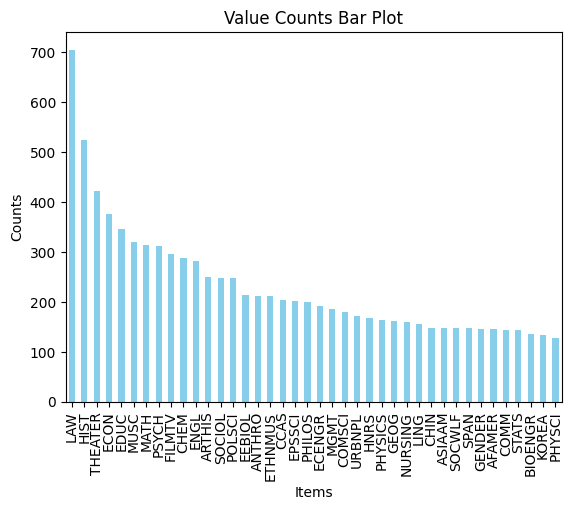

In [122]:
# Exploratory Data Analysis
import matplotlib.pyplot as plt

# Restrict to 40 areas that contain the most courses in the Registrar
area_counts = df['subject_area'].value_counts()[:40]

# Step 2: Create bar plot
area_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts Bar Plot')
plt.xlabel('Items')
plt.ylabel('Counts')
plt.show()

The above distribution demonstrates, in decreasing order, the top 20 subject areas with the most courses! We see that the MATH department is positioned 7th :)

Now, a cool experiment would be: can we find MATH156?

In [123]:
# Can we find MATH156?
math_156 = df[df["code"] == "MATH156"]
math_156["vector"]

10467    [-0.40762227773666304, -0.04837489128112701, 0...
Name: vector, dtype: object

Indeed, we find MATH156 in the dataset!

## Finding similar courses to MATH156

What if we use our embeddings to find courses whose descriptions are similar to MATH156?

In [124]:
# Function to calculate cosine similarity and find closest courses (by default, returns all similarities to the target course)
def find_closest_courses(df, target_vector, k=len(df)):

    # Extract vectors from DataFrame
    vectors = df['vector'].tolist()
    
    # Calculate cosine similarity for each vector
    similarities = []
    i = 1
    for vec in vectors:
        similarities.append(cosine_similarity(target_vector, np.array(vec)))
        i+=1
    
    # Get indices of the top N similar courses
    top_indices = np.argsort(similarities)[::-1][:k]
    
    # Select the top N similar courses
    closest_courses = df.iloc[top_indices].copy()
    closest_courses.loc[:, 'similarity'] = np.array(similarities)[top_indices]  # Adding similarity for display purpose only
    
    return closest_courses

# Pretty print the result of the closets_courses
def pretty_print_courses(df, n=8):
    """
    Prints the first n rows of the DataFrame's title and description columns in a pretty format.
    
    Parameters:
    df (DataFrame): The DataFrame containing course information.
    n (int): Number of rows to print.
    """
    if n > len(df):
        n = len(df)
    
    columns = ['code', 'description']
    max_lengths = {col: max(df[col].astype(str).apply(len).max(), len(col)) for col in columns}
    
    # Print each row
    for i in range(n):
        row = " | ".join([str(df.iloc[i][col]).ljust(max_lengths[col]) for col in columns])
        print(row)
        print('\n')

# Find top 5 courses similar to MATH156
closest_courses = find_closest_courses(df, math_156["vector"], k=len(df))
closest_courses

,subject_area,title,code,units,div,description,link,vector,similarity
10467,MATH,156. Machine Learning,MATH156,4.0,Upper Division Courses,"Lecture, three hours; discussion, one hour. Re...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.40762227773666304, -0.04837489128112701, 0...",1.000000
14644,STATS,102B. Introduction to Computation and Optimiza...,STATS102B,4.0,Upper Division Courses,"Lecture, three hours; discussion, one hour. Re...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.45220729708671503, 0.0028922730125480003, ...",0.966233
4899,ECENGR,M146. Introduction to Machine Learning,ECENGRM146,4.0,Upper Division Courses,"(Same as Computer Science M146.) Lecture, four...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.280435532331466, 0.13453914225101402, 0.29...",0.964971
3243,COMSCI,M146. Introduction to Machine Learning,COMSCIM146,4.0,Upper Division Courses,(Same as Electrical and Computer Engineering M...,https://catalog.registrar.ucla.edu/course/2023...,"[-0.25595298409461903, 0.122746810317039, 0.27...",0.964515
1788,BIOSTAT,M257. Computational Methods for Biostatistical...,BIOSTATM257,4.0,Graduate Courses,(Formerly numbered 257.) (Same as Biomathemati...,https://catalog.registrar.ucla.edu/course/2023...,"[-0.513464093208313, 0.046863790601491005, 0.2...",0.962808
...,...,...,...,...,...,...,...,...,...
9333,LAW,628. Prison Law,LAW628,1.0,Law Courses,,https://catalog.registrar.ucla.edu/course/2023...,"[-0.009229242801666001, -0.221859037876129, -0...",0.303080
9334,LAW,629. Post-Conviction Law & Policy,LAW629,1.0,Law Courses,,https://catalog.registrar.ucla.edu/course/2023...,"[-0.009229242801666001, -0.221859037876129, -0...",0.303080
9335,LAW,630. Immigration Law & Crimes,LAW630,1.0,Law Courses,,https://catalog.registrar.ucla.edu/course/2023...,"[-0.009229242801666001, -0.221859037876129, -0...",0.303080
9336,LAW,631. PLEA BARGAINING,LAW631,1.0,Law Courses,,https://catalog.registrar.ucla.edu/course/2023...,"[-0.009229242801666001, -0.221859037876129, -0...",0.303080


In [125]:
pretty_print_courses(closest_courses, n=6)

MATH156       | Lecture, three hours; discussion, one hour. Requisites: courses 115A, 164, 170A or 170E or Statistics 100A, and Computer Science 31 or Program in Computing 10A. Strongly recommended requisite: Program in Computing 16A or Statistics 21. Introductory course on mathematical models for pattern recognition and machine learning. Topics include parametric and nonparametric probability distributions, curse of dimensionality, correlation analysis and dimensionality reduction, and concepts of decision theory. Advanced machine learning and pattern recognition problems, including data classification and clustering, regression, kernel methods, artificial neural networks, hidden Markov models, and Markov random fields. Projects in MATLAB to be part of final project presented in class. P/NP or letter grading.                                                                                                                                                                                   

**The results above start to hint at the power of similarity search with vector embeddings!**

Note that courses with very high cosine similarity, the ones printed above, are indeed very similar in their description. Their embeddings, thus, were mapped to a similar region in the latent space.

Interesting to note is that they do not necessarily share specific keywords or equal phrases in common in their descriptions. This is precisely the power of embeddings! They are able to group similar text chunks together based on *semantic meaning* rather than simple keyword analysis.

**Fun fact:** I am actually taking STATS102B alongside this course this quarter, which happens to be the most similar course according to *BERT* to MATH156! This suggests that I probably chose my schedule right. ;)

## Implementing course suggestions

Now that we made a quick sanity check, we can start to play around with embedding user input (which would be our target vector) and computing its cosine similarity to all other courses in the dataset. This would ideally allow us to find courses whose descriptions are similar to what we are looking for.

Let us try one that sounds a little crazy to test it out.

In [151]:
user_input = "Topics related to feminism and the empowerment of woman"

In [152]:
# Enbed user input
embedded_input = pd.Series([text_to_bert_embeddings(user_input)])

# Perform similarity search!
closest_courses_to_input = find_closest_courses(df, embedded_input, k=6)
closest_courses_to_input

,subject_area,title,code,units,div,description,link,vector,similarity
3003,COMHLT,226. Women's Health and Well-Being,COMHLT226,4.0,Graduate Courses,"Lecture, four hours. Limited to graduate stude...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.43297788500785805, 0.09635730832815101, -0...",0.737344
6471,GENDER,103. Knowledge,GENDER103,4.0,Upper Division Courses,"Lecture, three hours; discussion, one hour (wh...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.127733185887336, 0.21749141812324502, -0.1...",0.731385
11995,PHILOS,167. Feminist Issues in Value Theory,PHILOS167,4.0,Upper Division Courses,"Lecture, three hours; discussion, one hour (wh...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.22560553252696902, 0.073309667408466, -0.0...",0.727970
6517,GENDER,139. Women and Art in Contemporary U.S.,GENDER139,4.0,Upper Division Courses,"Lecture/discussion, three hours. Requisite: co...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.287517011165618, 0.108340039849281, -0.231...",0.721494
6504,GENDER,130. Women of Color in the U.S.,GENDER130,4.0,Upper Division Courses,"Lecture/discussion, three hours. Requisite: co...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.356727749109268, 0.06766065210103901, -0.2...",0.715999
1293,ASIAAM,50. Asian American Women,ASIAAM50,5.0,Lower Division Courses,"Lecture, three hours; discussion, one hour. Ov...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.203724086284637, 0.126566469669342, -0.199...",0.715682


In [153]:
pretty_print_courses(closest_courses_to_input)

COMHLT226 | Lecture, four hours. Limited to graduate students. Interdisciplinary perspective critically examining research on women's health. Overview of scientific inquiry and methods; gender roles; status attainment and medical sociology. Review of current data on women's health. Letter grading.                                                                                                                                                                                                                                                                                                                           


GENDER103 | Lecture, three hours; discussion, one hour (when scheduled). Enforced requisite: course 10. Exploration of social production of knowledge about gendered subjects and gender systems. Students engage key issues in feminist theory and feminist epistemology. How do feminist scholars identify and frame research questions? How is knowledge about marginalized subjects produced

Not bad at all! Note that the similarity scores are not as high. A big reason is that the input text structure differs from the standardized descriptions of the courses–this is not as optimal as if you picked one that has the similar standardized format. Nonetheless, we still get great suggestions for our top 6 choices! We successfuly reached the latent region we wanted to reach with our input vector.

## Summarizing our Similarity Search into a single function

In [129]:
df = pd.read_json("ucla_courses.json")

def course_recommender(course_description, courses=df, n=6):

    # Embed course description
    embedded_input = pd.Series([text_to_bert_embeddings(course_description)])
    
    # Compute cosine similarity
    closest_courses = find_closest_courses(df, embedded_input)

    # Print n closest courses
    pretty_print_courses(closest_courses)

    return closest_courses

Now it is your time to test it out!

Substitute the input for your desired course description. **Remember, for it to work optimally, it is best to write in a similar way that the Registrar writes**:

In [159]:
input = "Topics include how to improve your social skills and self-improvement"

In [160]:
course_recommender(input)

PSYCH137J     | Seminar, three hours. Requisite: course 10. Designed for juniors/seniors. Examination of theory and research that addresses self from social psychological perspective. Topics focus on self-knowledge, how self is represented in memory, illusions about self, self-esteem, implicit (subconscious) self, self-regulation, social comparison, self-relevant emotions, and influence of culture on self. P/NP or letter grading.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

,subject_area,title,code,units,div,description,link,vector,similarity
13048,PSYCH,137J. Self and Identity,PSYCH137J,4.0,Upper Division Courses,"Seminar, three hours. Requisite: course 10. De...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.11879143863916301, 0.251517623662948, 0.01...",0.801677
4714,EDUC,261F. Seminar: Cognitive and Personal Developm...,EDUC261F,4.0,Graduate Courses,"Seminar, four hours. Examination of cognitive ...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.174471646547317, 0.23292766511440202, 0.00...",0.800680
4783,EDUC,407. Psychological Foundations of Education,EDUC407,3.0,Graduate Courses,"Lecture, three hours. Analysis of learning pro...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.274717390537261, 0.428124904632568, -0.061...",0.798967
13004,PSYCH,124G. Cognition and Successful Aging,PSYCH124G,4.0,Upper Division Courses,"Lecture, three hours. Requisite: course 120A o...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.09319254010915701, 0.22439610958099301, 0....",0.794402
13169,PSYCH,M242G. Seminar: Developmental Psychology--Adol...,PSYCHM242G,4.0,Graduate Courses,"Seminar, four hours. Designed for graduate stu...",https://catalog.registrar.ucla.edu/course/2023...,"[-0.374134182929992, 0.216141909360885, -0.026...",0.794075
...,...,...,...,...,...,...,...,...,...
9187,LAW,473. Advanced Written Advocacy Workshop,LAW473,1.0,Law Courses,,https://catalog.registrar.ucla.edu/course/2023...,"[-0.009229242801666001, -0.221859037876129, -0...",0.350424
9188,LAW,474. Advanced Oral Argumentation Workshop,LAW474,1.0,Law Courses,,https://catalog.registrar.ucla.edu/course/2023...,"[-0.009229242801666001, -0.221859037876129, -0...",0.350424
9189,LAW,475. U.S. Constitutional Law for Foreign Lawye...,LAW475,1.0,Law Courses,,https://catalog.registrar.ucla.edu/course/2023...,"[-0.009229242801666001, -0.221859037876129, -0...",0.350424
9190,LAW,476. Torts for Foreign Lawyers,LAW476,1.0,Law Courses,,https://catalog.registrar.ucla.edu/course/2023...,"[-0.009229242801666001, -0.221859037876129, -0...",0.350424


## Conclusion

This notebook demonstrates the potential of vector embeddings to perform similarity search with the example of UCLA courses. We were able to successfully find courses that are similar to MATH156, as well as get suggested courses according to a descriptional input.

There are, nonetheless, a few remarks I would like to make:

- Vector embeddings are just like any machine-learning model. They work best for a good-quality input–in this case, if the overall semantic structure of the input is similar to that of the embeddings we are searching against. This is why we got higher scores for when we were just using the standardized descriptions, rather than when we used arbitrarily formed user input.

- BERT is not the state-of-the-art model for semantic search. OpenAI's ADA embedding models would have probably performed better in this scenario. Still, we got significant results using just open-source BERT.

- Implementing the full RAG pipeline–that is, connecting the retrieved courses to an LLM that can think and reason with them–would be a more complex task. While it is still feasible, there are many other aspects, as explained in the paper, that need to be taken care of to make sure that the accuracy of responses is high.

## THANK YOU :)